In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [20]:
def make_pred(x, w, b):
    return np.matmul(x, w) + b

def compute_cost(x, y, w, b):
    sqr_diff = (make_pred(x, w, b) - y)**2
    return sqr_diff.sum() / (2*x.shape[0])

def run_grad_decent(x, y, w, b, alpha):
    cost_sum = ((make_pred(x, w, b)-y).sum() / x.shape[1])
    new_b = b - alpha * cost_sum

    j = x.shape[1]
    i = x.shape[0]

    preds = x*(np.matmul(x, w) + b - y)
    new_w = np.sum(preds, axis=0)

    new_w /= i
    new_w = w - (alpha * new_w.reshape([j, 1]))

    return new_w, new_b

def run_linear_regression(x, y, alpha = .004, iter = int(1e3)*2):    
    update_alpha = True
    j = x.shape[1]
    w = np.zeros([j, 1])
    b = 0
    cost_history = []
    print(b)
    cost_history.append(compute_cost(x, y, w, b))
    print(cost_history[-1])
    for _ in range(iter):
        new_w, new_b = run_grad_decent(x, y, w, b, alpha)
        cost_history.append(compute_cost(x, y, new_w, new_b))
        float('nan')
        if math.isinf(cost_history[-1]) or math.isnan(cost_history[-1]) or cost_history[-1] >= cost_history[-2]:
            alpha -= .001
            update_alpha = False
            new_w, new_b = w, b
            cost_history.pop()
        elif update_alpha:
            alpha += .001
        w, b = new_w, new_b
    print(compute_cost(x, y, w, b))
    return w, b, cost_history 

0
1.4051423544996315
0.9044157801171571
0
1.4051423544996315
0.6602166166301597
0
1.4051423544996315
0.40304752316970993
0
1.4051423544996315
0.35322532352672364


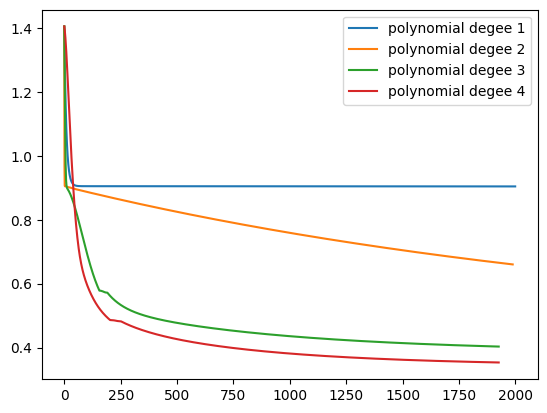

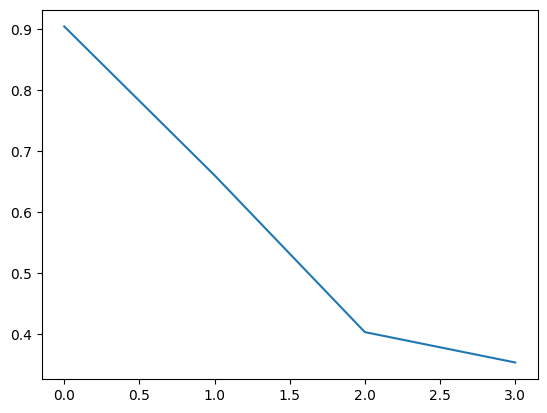

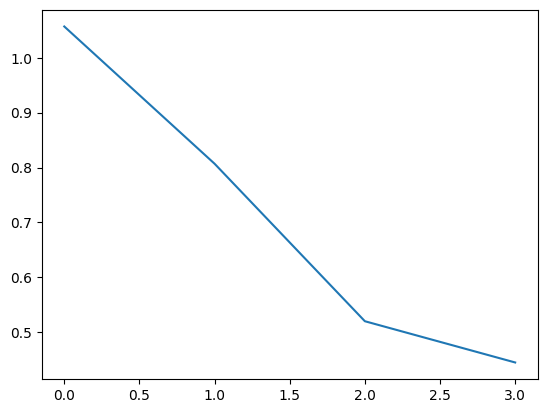

0.5222765656906478


In [21]:
def import_data_set():
    # Grab dataset from file
    car_dataframe = pd.read_csv("data/car details v4.csv")
    data = (car_dataframe.loc[:, ["Fuel Tank Capacity", "Year", "Price"]]).to_numpy().astype('float64')
    return data

def create_data_sets(data):
    # Use simple data cleaning of dropping all null data
    data_clean = data[~np.isnan(data).any(axis=1)]

    # Suffle data insure equal distabution between train, validation, and test sets (Also use seed to insure determinisum)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(data_clean)

    # Split up data set into train, validation, and test
    train_set_end_index = int(data_clean.shape[0]/2)
    validation_set_end_index = int(3*data_clean.shape[0]/4)
    train_set = data_clean[:train_set_end_index]
    validation_set = data_clean[train_set_end_index:validation_set_end_index]
    test_set = data_clean[validation_set_end_index:]

    train_set_inputs = train_set[:, :2]
    train_set_targets = train_set[:, 2:]
    validation_set_inputs = validation_set[:, :2]
    validation_set_targets = validation_set[:, 2:]
    test_set_inputs = test_set[:, :2]
    test_set_targets = test_set[:, 2:]

    return train_set_inputs, train_set_targets, validation_set_inputs, validation_set_targets, test_set_inputs, test_set_targets

def normalize_datasets(train_set_inputs, train_set_targets, validation_set_inputs, validation_set_targets, test_set_inputs, test_set_targets):
    normalized_train_set_inputs = train_set_inputs
    normalized_validation_set_inputs = validation_set_inputs
    normalized_test_set_inputs = test_set_inputs

    for j in range(train_set_inputs.shape[1]):
        train_set_column = normalized_train_set_inputs[:, j:j+1]
        validation_set_column = normalized_validation_set_inputs[:, j:j+1]
        test_set_column = normalized_test_set_inputs[:, j:j+1]

        sigma = train_set_column.std()
        mean = train_set_column.mean()

        normalized_train_set_inputs[:, j:j+1] = (train_set_column - mean) / sigma / 100
        normalized_validation_set_inputs[:, j:j+1] = (validation_set_column - mean) / sigma / 100
        normalized_test_set_inputs[:, j:j+1] = (test_set_column - mean) / sigma / 100
        
    train_set_targets_mean = train_set_targets.mean()

    normalized_train_set_targets = train_set_targets / train_set_targets_mean
    normalized_validation_set_targets = validation_set_targets / train_set_targets_mean
    normalized_test_set_targets = test_set_targets / train_set_targets_mean

    return normalized_train_set_inputs, normalized_train_set_targets, normalized_validation_set_inputs, normalized_validation_set_targets, normalized_test_set_inputs, normalized_test_set_targets 

def get_next_polynomial_set(normalized_trained_inputs):
    num_of_examples = normalized_trained_inputs.shape[0]
    num_of_inputs = normalized_trained_inputs.shape[1]

    next_polynomal_set = np.empty([num_of_examples, num_of_inputs**2+num_of_inputs])

    for i in range(num_of_examples):
        for j in range(num_of_inputs):
            next_polynomal_set[i, j] = normalized_trained_inputs[i, j]

    for i in range(num_of_examples):
        index = 0
        for j in range(num_of_inputs):
            for k in range(num_of_inputs):
                next_polynomal_set[i, index+num_of_inputs] = normalized_trained_inputs[i, j] * normalized_trained_inputs[i, k]
                index += 1
            
    return next_polynomal_set 


def create_polynomial_datasets(normalized_train_set_inputs, normalized_validation_set_inputs, normalized_test_set_inputs, polynomial_degree):
    normalized_polynomial_train_set_targets = [normalized_train_set_inputs]
    normalized_polynomial_validation_set_inputs = [normalized_validation_set_inputs]
    normalized_polynomial_test_set_inputs = [normalized_test_set_inputs]

    for _i in range(polynomial_degree-1):
        normalized_polynomial_train_set_targets.append(get_next_polynomial_set(normalized_polynomial_train_set_targets[-1]))
        normalized_polynomial_validation_set_inputs.append(get_next_polynomial_set(normalized_polynomial_validation_set_inputs[-1]))
        normalized_polynomial_test_set_inputs.append(get_next_polynomial_set(normalized_polynomial_test_set_inputs[-1]))

    scaling_factor = 10

    for i in range(1, len(normalized_polynomial_train_set_targets)):
        train_set_targets = normalized_polynomial_train_set_targets[i]
        validation_set_targets = normalized_polynomial_validation_set_inputs[i]
        test_set_targets = normalized_polynomial_test_set_inputs[i]
        
        num_of_targets = train_set_targets.shape[1]
        for j in range(num_of_targets):
            mean = train_set_targets[:, j:j+1].mean()
            sigma = train_set_targets[:, j:j+1].std()

            train_set_targets[:, j:j+1] = (train_set_targets[:, j:j+1] - mean) / sigma / scaling_factor
            validation_set_targets[:, j:j+1] = (validation_set_targets[:, j:j+1] - mean) / sigma / scaling_factor
            test_set_targets[:, j:j+1] = (test_set_targets[:, j:j+1] - mean) / sigma / scaling_factor
        
    return normalized_polynomial_train_set_targets, normalized_polynomial_validation_set_inputs, normalized_polynomial_test_set_inputs

data_set = import_data_set()

train_set_inputs, train_set_targets, validation_set_inputs, validation_set_targets, test_set_inputs, test_set_targets = create_data_sets(data_set)
normalized_train_set_inputs, normalized_train_set_targets, normalized_validation_set_inputs, normalized_validation_set_targets, normalized_test_set_inputs, normalized_test_set_targets  = normalize_datasets(train_set_inputs, train_set_targets, validation_set_inputs, validation_set_targets, test_set_inputs, test_set_targets)

polynomial_degree = 4

normalized_polynomial_train_set_targets, normalized_polynomial_validation_set_inputs, normalized_polynomial_test_set_inputs = create_polynomial_datasets(normalized_train_set_inputs, normalized_validation_set_inputs, normalized_test_set_inputs, polynomial_degree)

cost_histories = []
learned_wb = []

for i in range(polynomial_degree):
    w, b, cost_history = run_linear_regression(normalized_polynomial_train_set_targets[i], normalized_train_set_targets)
    learned_wb.append((w,b))
    cost_histories.append(cost_history)

for i in range(len(cost_histories)):
    x = cost_histories[i]
    plt.plot(x, label = f"polynomial degee {i+1}") 

plt.legend()
plt.show()

final_cost = []

for i in range(len(cost_histories)):
    final_cost.append(cost_histories[i][-1])

plt.plot(final_cost) 
plt.show()

validation_set_costs = []

for i in range(polynomial_degree):
    w, b = learned_wb[i]
    cost = compute_cost(normalized_polynomial_validation_set_inputs[i], normalized_validation_set_targets, w, b)
    validation_set_costs.append(cost)

plt.plot(validation_set_costs) 
plt.show()

print(compute_cost(normalized_polynomial_test_set_inputs[-1], normalized_test_set_targets, w, b))
